<a href="https://colab.research.google.com/github/rex17/Machine-Learning-Practice/blob/master/EducatedGuessClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning in Python - Roll your Own Estimator Example

This notebooks demonstrates how scikit-learn can be extended to include new models by implementing the **EducatedGuessClassifier**. 

The **EducatedGuessClassifier** is a **very naive** classification algorithm that calculates the distribution across classes in a training dataset and when asked to make a prediction returns a random class selected according to that distribution. The EducatedGuessClassifier only works for categorical target features. 

The EducatedGuessClassifier is very simple:
* **Training:** Simply calculate the distribtion across the target levels in the trianing dataset. And store these as a map.
* **Prediction:** When a new prediction needs to draw a random value from the sistrubiton ddefined based on the training dataset. 

**NOTE THAT THE EDUCATEDGUESSCLASSIFIER IS A TERRIBLE MODEL AND IS ONLY USED AS A VERY SIMPLE DEMONSTRATION OF HOW TO IMPLEMENT AN ML ALGORITHM IN SCIKIT-LEARN**

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving fashion-mnist_test.csv to fashion-mnist_test.csv
Saving fashion-mnist_train.csv to fashion-mnist_train.csv
User uploaded file "fashion-mnist_test.csv" with length 22176691 bytes
User uploaded file "fashion-mnist_train.csv" with length 133047193 bytes


## Import Packages Etc

In [0]:
from IPython.display import display, HTML, Image

from TAS_Python_Utilities import data_viz
from TAS_Python_Utilities import data_viz_target
from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from scipy.spatial import distance


%matplotlib inline
#%qtconsole

## Define EducatedGuessClassifier

Define and test out the EducatedGuessClassifier class. To build a scikit-learn classifier we extend from the **BaseEstimator** and **ClassifierMixin** classes and implement the **init**, **fit**, **predict**, and **predict_proba** methods.

### Define the EducatedGuessClassifier Class

In [0]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class EducatedGuessClassifier(BaseEstimator, ClassifierMixin):
    """The EducatedGuessClassifier is a very naive classification algorithm that calculates the distribution across classes in a training dataset and when asked to make a prediction returns a random class selected according to that distribution. The EducatedGuessClassifier only works for categorical target features. 
        - Training: 
            Simply calculate the distribtion across the target levels 
            in the trianing dataset. And store these as a map.
        - Prediction: 
            When a new prediction needs to draw a random value from the distrubiton 
            defined based on the training dataset. 

    Parameters
    ----------
    add_noise string, optional (default = False)
        Whether or not a little bit of noise should be added to the distribution.

    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The class labels (single output problem).
    distribution_: dict
        A dictionary of the probability of each class.
        
    Notes
    -----
    

    See also
    --------
    
    ----------
    
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = EducatedGuessClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    
    # Constructor for the classifier object
    def __init__(self, add_noise = False):
        self.add_noise = add_noise

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a decision tree classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csc_matrix``.
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """
            
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Count the number of occurrences of each class in the target vector 
        # (uses numpy unique function that returns a list of unique values and their counts)
        unique, counts = np.unique(y, return_counts=True)
        
        # Store the classes seen during fit
        self.classes_ = unique

        # Normalise the counts to sum to 1
        dist = counts/sum(counts)
            
        # If the add_noise attribute is true add a little noise to the distribution
        if(self.add_noise):
            for i in  range(len(dist)):
                dist[i] = dist[i] + dist[i]*random.uniform(-0.25, 0.25)
            # Renormalise the distribution
            dist = dist/sum(dist)
            
        # Create a new dictionary of classes and their normalised frequencies (the distribution)
        self.distribution_ = dict(zip(unique, dist))
        
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like or sparse matrix of shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the distributions_ dictionary has been set up
        check_is_fitted(self, ['distribution_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)

        # Initialise an empty list to store the predictions made
        predictions = list()
        
        # Iterate through the query instances in the query dataset 
        for instance in X:
            
            #Generate a random class according to the learned distribution
            pred = random.choices(list(self.distribution_.keys()), list(self.distribution_.values()))
            
            predictions.append(pred[0])
            
        return np.array(predictions)
    
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        
        # Check is fit had been called by confirming that the distributions_ dictionary has been set up
        check_is_fitted(self, ['distribution_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)

        # Initialise an array to store the prediction scores generated
        predictions = np.zeros((len(X), len(self.classes_)))

        # Iterate through the query instances in the query dataset 
        for idx, instance in enumerate(X):
            
            #Generate a random class according to the learned distribution
            pred = random.choices(list(self.distribution_.keys()), list(self.distribution_.values()))[0]

            # Always give the predicted class a probability of 0.9 and all other classes the remining probability mass  equally distributed.
            predictions[idx, ]= 0.1/(len(self.classes_) - 1)
            predictions[idx, list(self.classes_).index(pred)] = 0.9
            
        return predictions

### Test the EducatedGuessClassifier

Do a simple test of the EducatedGuessClassifier

In [0]:
a = np.array([[1,23,3,4], [5,6,7,8], [7,5,6,2], [4,9,12,43]])
y = np.array([1, 2, 2, 2])

In [0]:
my_model = EducatedGuessClassifier()

In [8]:
my_model.fit(a, y)

EducatedGuessClassifier(add_noise=False)

In [9]:
my_model.distribution_

{1: 0.25, 2: 0.75}

In [0]:
q = np.array([[2,15,6,21], [8,9,7,6]])

In [11]:
my_model.predict(q)

array([2, 1])

In [12]:
my_model.predict_proba(q)

array([[0.1, 0.9],
       [0.1, 0.9]])

Fit a model to the iris dataset

In [13]:
from sklearn.datasets import load_iris
iris = load_iris()

clf = EducatedGuessClassifier()
clf.fit(iris.data, iris.target)
clf.distribution_

{0: 0.3333333333333333, 1: 0.3333333333333333, 2: 0.3333333333333333}

Do simple Iris cross validation expeirment

In [14]:
clf = EducatedGuessClassifier()
cross_val_score(clf, iris.data, iris.target, cv=10)

array([0.26666667, 0.33333333, 0.33333333, 0.4       , 0.4       ,
       0.33333333, 0.4       , 0.33333333, 0.33333333, 0.4       ])

Fit a model to the iris dataset with noise added to the distribution

In [15]:
clf = EducatedGuessClassifier(add_noise = True)
clf.fit(iris.data, iris.target)
clf.distribution_

{0: 0.36506740438251944, 1: 0.25784767072720716, 2: 0.3770849248902733}

In [16]:
from sklearn.datasets import load_iris
clf = EducatedGuessClassifier(add_noise = True)
iris = load_iris()
cross_val_score(clf, iris.data, iris.target, cv=10)

array([0.53333333, 0.26666667, 0.2       , 0.2       , 0.4       ,
       0.2       , 0.53333333, 0.33333333, 0.26666667, 0.4       ])

## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [0]:
data_sampling_rate = 0.1

Setup the number of folds for all grid searches (should be 5 - 10)

In [0]:
cv_folds = 10

### Load & Partition Data

Load the dataset and explore it.

In [19]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) 
#take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
30379,4,0,0,0,0,0,0,1,0,0,...,0,2,0,62,206,190,0,0,0,0
33224,2,0,0,0,0,0,0,0,0,0,...,37,28,0,72,189,168,54,0,0,0
8134,8,0,0,0,0,0,0,0,0,0,...,48,49,50,51,31,38,36,12,0,0
11519,4,0,0,0,0,0,0,0,0,0,...,2,0,27,160,148,0,0,0,0,0
9270,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Isolate the descriptive features we are interested in

In [0]:
X = dataset[dataset.columns.difference(["label"])]
Y = np.array(dataset["label"])

In [21]:
dataset.columns.difference(["label"])

Index(['pixel1', 'pixel10', 'pixel100', 'pixel101', 'pixel102', 'pixel103',
       'pixel104', 'pixel105', 'pixel106', 'pixel107',
       ...
       'pixel90', 'pixel91', 'pixel92', 'pixel93', 'pixel94', 'pixel95',
       'pixel96', 'pixel97', 'pixel98', 'pixel99'],
      dtype='object', length=784)

In [0]:
X = X/255

In [24]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Train and Evaluate a Simple Model

In [25]:
my_model = EducatedGuessClassifier(add_noise = True)
my_model.fit(X_train, y_train)

EducatedGuessClassifier(add_noise=True)

In [26]:
# Make a set of predictions for the training data
y_pred = my_model.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
display(pd.crosstab(y_train, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.10133333333333333
              precision    recall  f1-score   support

           0       0.12      0.15      0.14       294
           1       0.10      0.12      0.11       296
           2       0.10      0.08      0.09       316
           3       0.08      0.07      0.07       289
           4       0.12      0.09      0.10       275
           5       0.11      0.12      0.12       295
           6       0.11      0.08      0.10       331
           7       0.10      0.10      0.10       317
           8       0.08      0.09      0.08       298
           9       0.10      0.11      0.10       289

   micro avg       0.10      0.10      0.10      3000
   macro avg       0.10      0.10      0.10      3000
weighted avg       0.10      0.10      0.10      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,44,39,17,20,17,31,21,26,41,38,294
1,36,37,23,18,29,30,23,35,33,32,296
2,44,41,25,29,16,34,29,29,37,32,316
3,22,34,33,20,33,34,24,28,32,29,289
4,30,27,16,20,24,25,29,34,34,36,275
5,28,29,29,28,13,36,24,27,43,38,295
6,44,45,36,24,19,30,28,34,42,29,331
7,32,40,28,37,19,35,28,31,35,32,317
8,34,36,29,22,22,34,20,36,27,38,298


In [27]:
# Make a set of predictions for the training data
y_pred = my_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.09277777777777778
              precision    recall  f1-score   support

           0       0.10      0.12      0.11       182
           1       0.09      0.08      0.08       191
           2       0.10      0.09      0.10       170
           3       0.10      0.08      0.09       194
           4       0.12      0.09      0.10       183
           5       0.08      0.09      0.09       170
           6       0.10      0.10      0.10       164
           7       0.09      0.08      0.09       181
           8       0.10      0.11      0.10       198
           9       0.06      0.08      0.07       167

   micro avg       0.09      0.09      0.09      1800
   macro avg       0.09      0.09      0.09      1800
weighted avg       0.09      0.09      0.09      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,21,12,18,18,11,24,14,20,22,22,182
1,23,16,19,23,23,17,11,17,19,23,191
2,22,21,16,9,8,22,8,18,24,22,170
3,23,21,9,15,21,23,23,14,18,27,194
4,17,23,18,14,17,19,14,15,21,25,183
5,15,20,19,15,14,16,13,23,17,18,170
6,16,14,13,13,16,22,16,11,25,18,164
7,20,20,15,19,13,17,14,15,24,24,181
8,21,23,24,16,11,18,20,18,21,26,198


## Do a Cross Validation Experiment With Our Model

In [28]:
my_model = EducatedGuessClassifier()
scores = cross_val_score(my_model, X_train_plus_valid, y_train_plus_valid, cv=cv_folds, n_jobs=-1)
print(scores)

[0.09647059 0.09433962 0.10165485 0.10189573 0.10189573 0.12380952
 0.10023866 0.10120482 0.10120482 0.0939759 ]


## Do a Grid Search Through Distance Metrics

In [29]:
# Set up the parameter grid to seaerch
param_grid = [
 {'add_noise': [False, True]}
]

# Perform the search
my_tuned_model = GridSearchCV(EducatedGuessClassifier(), param_grid, cv=cv_folds, verbose = 2, n_jobs=-1)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
print(my_tuned_model.best_score_)


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best parameters set found on development set:
{'add_noise': True}
0.09833333333333333


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished


In [30]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.10611111111111111
              precision    recall  f1-score   support

           0       0.10      0.10      0.10       182
           1       0.13      0.13      0.13       191
           2       0.12      0.12      0.12       170
           3       0.08      0.07      0.07       194
           4       0.09      0.10      0.10       183
           5       0.13      0.17      0.15       170
           6       0.09      0.09      0.09       164
           7       0.07      0.08      0.08       181
           8       0.13      0.12      0.13       198
           9       0.09      0.08      0.09       167

   micro avg       0.11      0.11      0.11      1800
   macro avg       0.11      0.11      0.11      1800
weighted avg       0.11      0.11      0.11      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,18,20,20,12,18,23,12,30,13,16,182
1,16,24,18,21,26,22,18,12,18,16,191
2,6,20,21,11,19,25,12,21,24,11,170
3,18,27,17,13,29,22,11,16,28,13,194
4,14,16,17,17,19,21,22,26,19,12,183
5,18,14,16,20,18,29,14,14,9,18,170
6,18,16,11,18,21,15,15,18,16,16,164
7,23,18,23,12,14,18,22,14,15,22,181
8,21,16,23,17,23,22,19,20,24,13,198


Demo the predict_proba function.

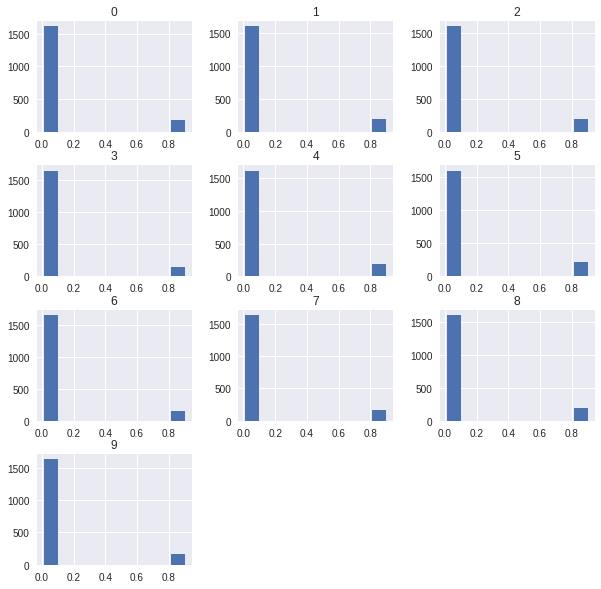

In [31]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict_proba(X_test)
_ = pd.DataFrame(y_pred).hist(figsize = (10,10))